In [1]:
import galprime as gp
gp.plotting.pyplot_style()

from astropy.io import fits
from astropy.table import Table
from astropy.modeling.models import Sersic2D

import numpy as np

from scipy.special import gamma
from scipy.signal import convolve2d

from matplotlib import pyplot as plt

from astropy.visualization import ZScaleInterval

from photutils.background import Background2D

In [2]:
config = gp.read_config_file("myconfig.gprime")
table = Table.read(f'{config["FILE_DIR"]}{config["FILES"]["CATALOGUE"]}')
table = gp.trim_table(table, config)


5


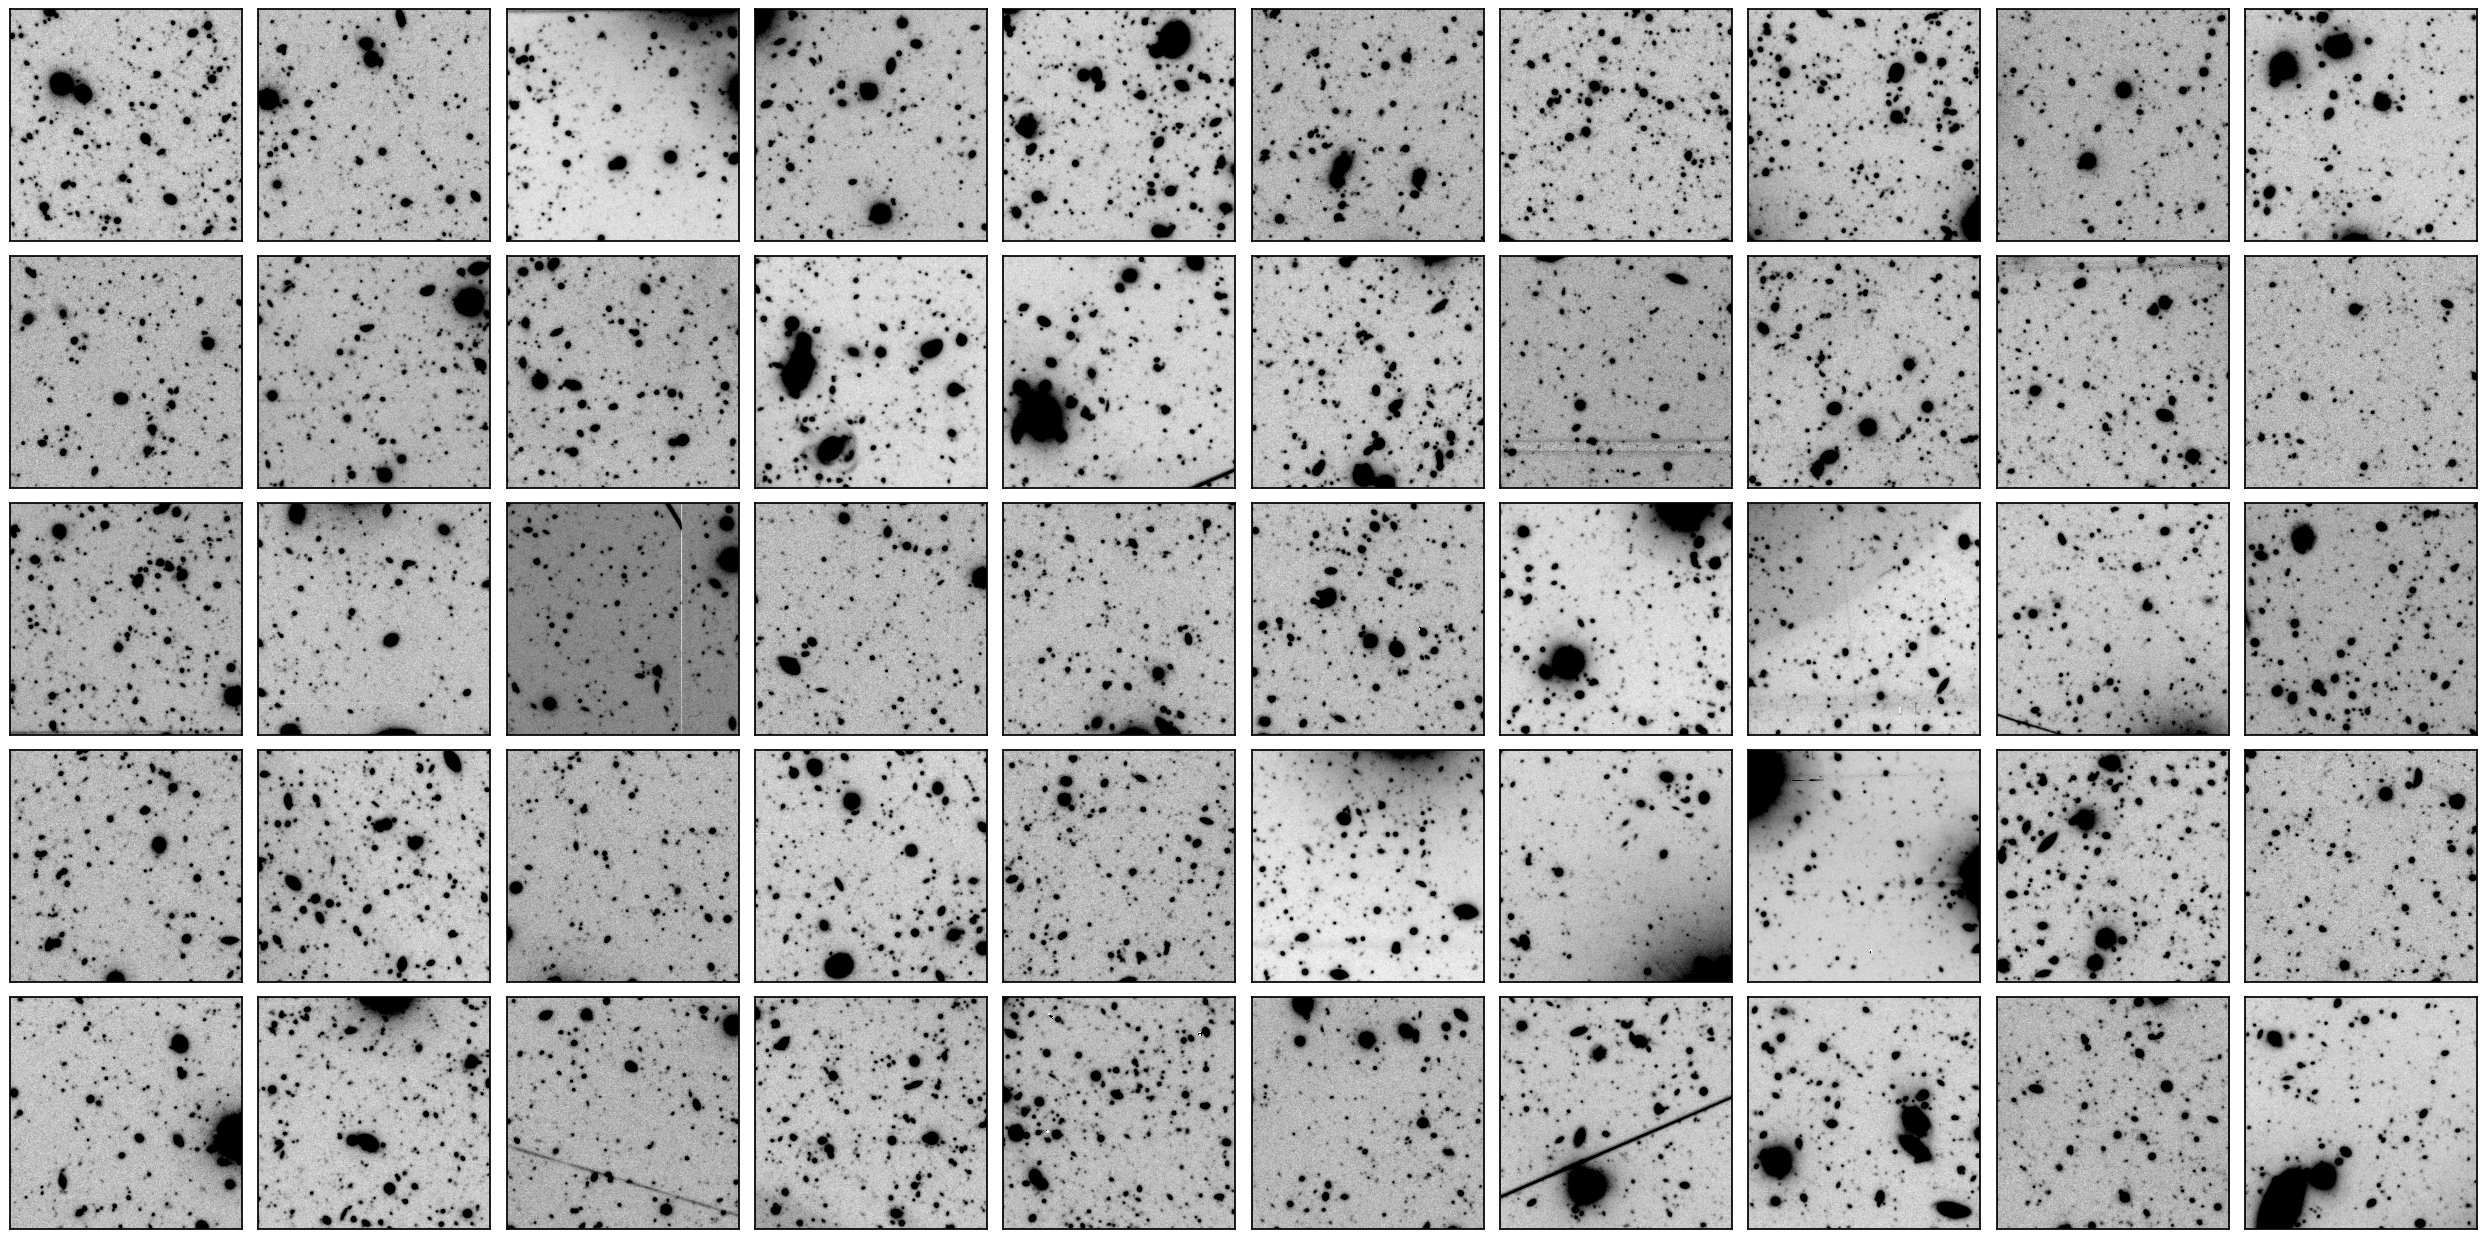

In [12]:

cutouts = gp.Cutouts.from_file("../pdata/cutouts_i.fits")
gp.plotting.show_cutouts(cutouts, ncols=10, outname="temp/cutouts_i.png", dpi=100)

psfs = gp.Cutouts.from_file("../pdata/i_psfs.fits")
psfs.cutouts = psfs.cutouts[:len(cutouts.cutouts)]

<class 'galprime.core.cutouts.Cutouts'>
5


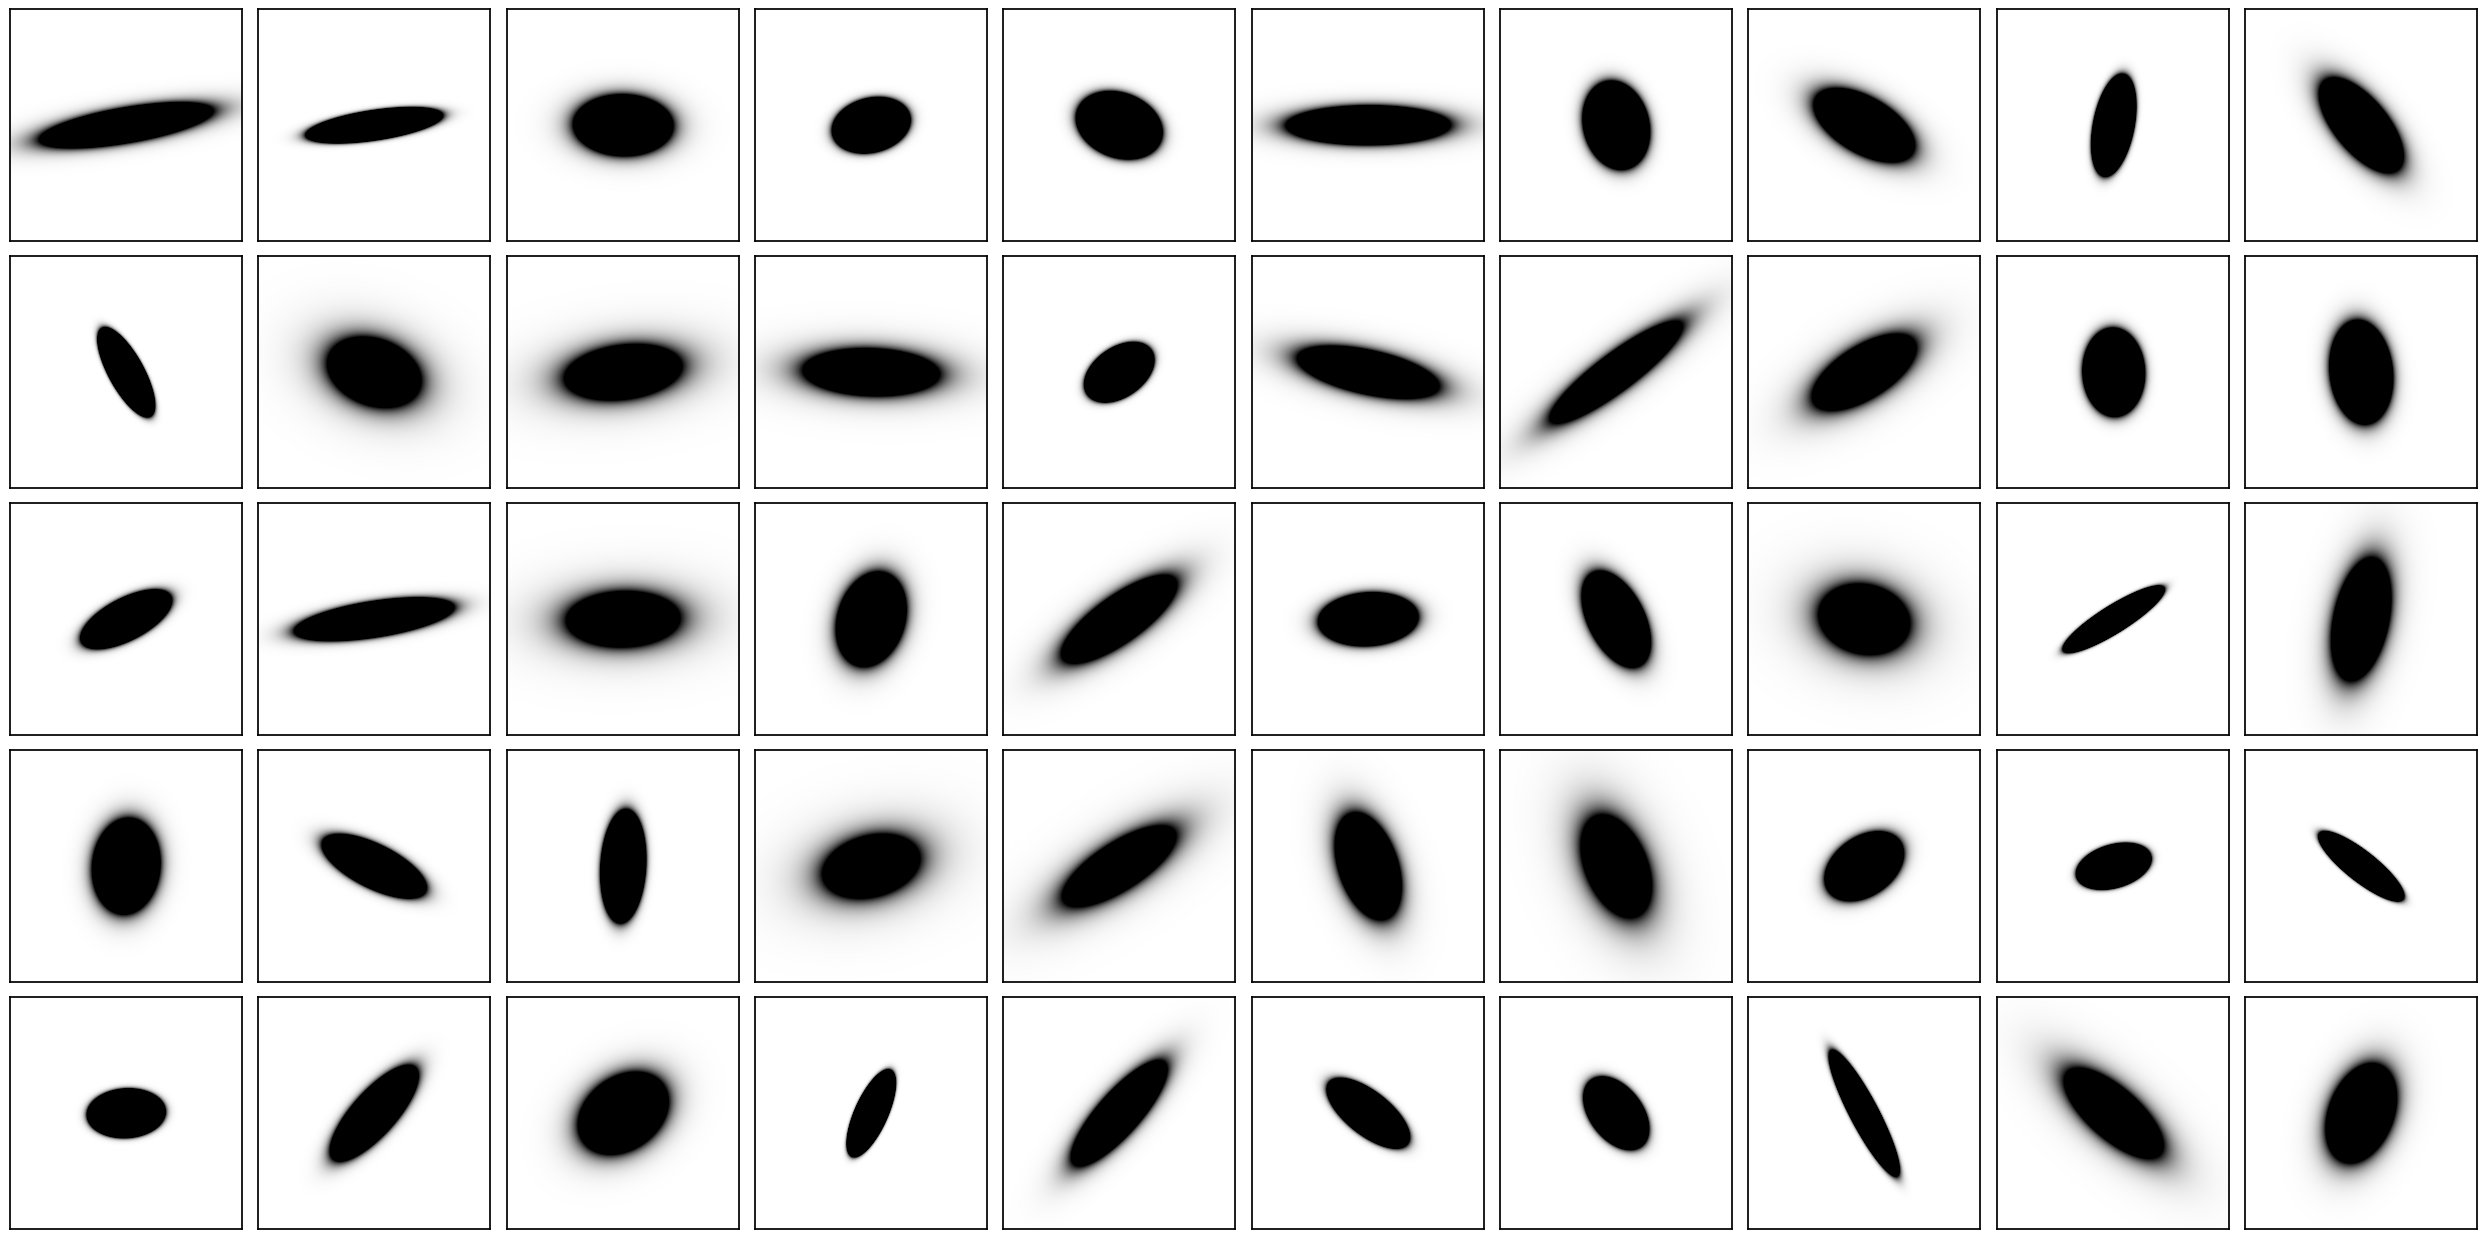

In [4]:

models = gp.gen_sersic_models(n_models=50, width=(451), mag_range=(17, 22))
print(type(models))
gp.plotting.show_cutouts(models, ncols=10, outname="temp/sersic_models.png", dpi=100)

In [15]:
model_template = gp.SingleSersicModel()

models = gp.Cutouts()
print(len(models.cutouts))

keys, kde = gp.setup_kde(model_template, config, table)

model_images = []
for _ in cutouts.cutouts:

    params = gp.sample_kde(config, keys, kde)
    params = gp.update_required(params, config)

    # print(params)

    mod, mod_params = model_template.generate(params)
    models.cutouts.append(mod)
    models.cutout_data.append(mod_params)

print(len(models.cutouts))

0
50


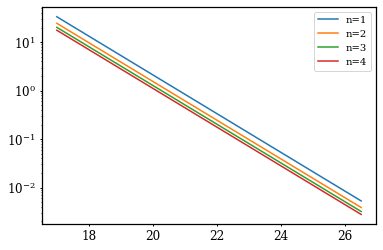

In [55]:
from scipy.special import gammainccinv
from scipy.special import gamma
from astropy.modeling.models import Sersic2D


def Ltot(m, ZPM=27):
    return 10 ** ((ZPM - m) / 2.5)


def b(n, estimate=False):
    """ Get the b_n normalization constant for the sersic profile. From Graham and Driver."""
    if estimate:
        return 2 * n - (1 / 3) + (4 / (405 * n)) + (46 / (25515 * (n ** 2)))
    else:
        return gammainccinv(2 * n, 0.5)


def I_e(mag, n, r_eff, zpm=27):
    L_tot = Ltot(mag, zpm)
    bn = b(n)
    return L_tot * (bn ** (2 * n)) / (2 * np.pi * r_e ** 2 * n  * np.exp(bn) * gamma(2 * n))


zpm = 27
mags = np.arange(17, 27, 0.5)
r_e = 5
for n in [1, 2, 3, 4]:
    I_e_vals = [I_e(m, n, r_e) for m in mags]
    plt.plot(mags, I_e_vals, label=f"n={n}")
plt.legend()
plt.yscale("log")



<ipython-input-94-b17fa6385ded>:18: RuntimeWarning: invalid value encountered in log10
  ax[1].imshow(np.log10(bg0 + 0.03), vmin=-8, vmax=0)
<ipython-input-94-b17fa6385ded>:19: RuntimeWarning: invalid value encountered in log10
  ax[2].imshow(np.log10(z + bg0 + 0.03), vmin=-8, vmax=0)


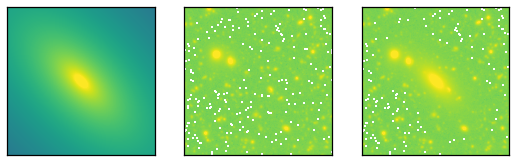

In [94]:
n=4
r_eff = 15
bg0 = cutouts.cutouts[0]
mag=19

ellipticity = 0.5
theta = np.pi / 4

mod = Sersic2D(amplitude=I_e(mag, n=n, r_eff=r_eff), r_eff=r_eff, n=n, x_0=bg0.shape[0] / 2, y_0=bg0.shape[1] / 2,
                ellip=ellipticity, theta=theta)
ys, xs = np.mgrid[:bg0.shape[0], :bg0.shape[1]]

z = mod(xs, ys)


fig, ax = plt.subplots(1, 3, facecolor="white", figsize=(9, 3))
ax[0].imshow(np.log10(z), vmin=-8, vmax=0)
ax[1].imshow(np.log10(bg0 + 0.03), vmin=-8, vmax=0)
ax[2].imshow(np.log10(z + bg0 + 0.03), vmin=-8, vmax=0)

for axis in ax:
    axis.set(xticks=[], yticks=[])


In [95]:
for c1, c2 in zip(models.cutouts, cutouts.cutouts):
    print(np.nansum(c1), np.nansum(c2), np.nansum(c1) / np.nansum(c2))



169.17507700655725 8721.616 0.01939721640060247
226.64253727153087 16387.266 0.013830406027334465
653.7658613933099 11655.18 0.05609230221430766
751.9731205870938 19097.432 0.0393756152522342
572.4444191422488 13093.445 0.04371992286825758
113.2175940049984 8439.786 0.013414746798479529
130.1843812902207 1898.7427 0.06856346726217416
105.67100133136258 7809.7837 0.013530592588324963
357.5944017077674 9285.757 0.03850998987221103
135.33149510965384 23392.004 0.00578537416683208
884.8034402866181 4273.4014 0.2070489907829424
227.68780599697317 19252.781 0.011826229314113937
92.32493919017915 7149.5356 0.012913417567307243
300.32619910212406 13411.703 0.022392845733537222
234.8132401115258 18133.898 0.01294885602899064
56.521884578436214 8223.342 0.006873347353738285
69.74080665793619 3533.909 0.01973474923375289
100.33427181308748 5398.826 0.018584460513986437
934.6886478046797 2228.9426 0.4193417257591603
145.58855542394278 2238.9565 0.06502518143156957
504.99204371894166 7129.847 0.070